In [20]:
#from IPython import clear_output
from IPython.display import clear_output
!bash -c "source ~/catkin_ws/devel/setup.bash && env"
clear_output()

In [ ]:
import sys
print(sys.executable)
print(sys.version)


In [22]:

import os
import rospy
import sys
import time
import numpy as np
import cv2
import math
import scipy
import rosbag


In [23]:
def read_bags(root_dir='User_data_with_video', limit = 300, start_num = 232):
    """
    Extracts data from all ROS bag files under subfolders user_<number> within the given root directory.
    
    The returned dictionary has the form:
        data[user_number][topic_name] = list of message objects
    
    :param root_dir: The directory containing subfolders named user_<number> with .bag files.
    :return: A nested dictionary of the extracted data.
    """
    
    data = {}
    id_index = []
    cnt = 0
    # List all items in root_dir
    for folder_name in os.listdir(root_dir):
        # We are only interested in folders that start with "user_"
        if folder_name.startswith("user_") and folder_name.split("_", 1)[1] >= str(start_num):
            cnt += 1
            # Extract the user number from folder name (e.g., user_100 -> "100")
            user_number = folder_name.split("_", 1)[1]
            id_index.append(user_number)
            user_dir = os.path.join(root_dir, folder_name)
            
            # Make sure it's actually a directory
            if not os.path.isdir(user_dir):
                continue
            
            # Initialize a dictionary for this user
            data[user_number] = {}
            
            # Find all .bag files inside this user directory
            bag_files = [
                f for f in os.listdir(user_dir)
                if f.endswith(".bag") and os.path.isfile(os.path.join(user_dir, f))
            ]
            
            for bag_file in bag_files:
                bag_path = os.path.join(user_dir, bag_file)
                
                print(f"Processing bag: {bag_path}")
                
                # Open the bag
                with rosbag.Bag(bag_path, 'r') as bag:
                    # Read all messages (topic, message, timestamp)
                    for topic, msg, t in bag.read_messages():
                        # If topic is not yet in data dict, initialize it
                        # if the topic contains camera_ then skip it
                        if topic not in data[user_number] and topic.find('camera') == -1:
                            data[user_number][topic] = []
                        
                        # Append the message to the list for this topic
                        if topic.find('camera') == -1:
                            data[user_number][topic].append(msg)
            if cnt > limit:
                break
    
    return data, id_index




data, id_index = read_bags('video_free_bags', 20)
print("Data extraction complete.")
print(f"Extracted data for {len(data)} users.")
print(f"User IDs: {id_index}")
print(f"Data keys: {data[id_index[0]].keys()}")





Data extraction complete.
Extracted data for 21 users.
User IDs: ['252', '239', '312', '314', '247', '277', '310', '240', '323', '285', '272', '302', '253', '322', '254', '325', '304', '260', '232', '311', '301']
Data keys: dict_keys(['/my_gen3_lite/in/cartesian_velocity', '/my_gen3_lite/joint_states', '/tf', '/my_gen3_lite/base_feedback', '/my_gen3_lite/base_feedback/joint_state', '/joy'])


In [24]:

def write_bags(data, id_index, output_dir='User_data_output'):
    """
    Writes the data from the nested dictionary to ROS bag files, creating one bag per user.
    
    :param data: The nested dictionary returned by read_bags(), 
                 structured as data[user_number][topic_name] = list of message objects.
    :param id_index: The list of user IDs.
    :param output_dir: The directory to store the newly created user_<id> folders and bag files.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Iterate through each user in our data
    for user_number in id_index:
        
        # Create a subdirectory for this user
        user_folder_name = f"user_{user_number}"
        user_dir = os.path.join(output_dir, user_folder_name)
        if not os.path.exists(user_dir):
            os.makedirs(user_dir)
        
        # We'll create a single bag file per user. Adjust naming as you wish.
        bag_file_name = f"user_{user_number}.bag"
        bag_path = os.path.join(user_dir, bag_file_name)
        
        print(f"Writing bag for user_{user_number} at: {bag_path}")
        
        # Open the bag for writing
        with rosbag.Bag(bag_path, 'w') as bag:
            # For each topic, write all messages into the bag
            for topic in data[user_number].keys():
                msg_list = data[user_number][topic]
                # If the original code doesn't store timestamps, create dummy ones.
                for idx, msg in enumerate(msg_list):
                    # Create a fake timestamp
                    # e.g., incremental or based on index
                    stamp = rospy.Time.from_sec(idx * 0.01)
                    bag.write(topic, msg, stamp)
                    
        print(f"Finished writing bag for user_{user_number}.\n")

# write_bags(data, id_index, 'video_free_bags')

In [25]:
import pandas as pd

# 1) Read your CSV file into a DataFrame
# Replace "my_file.csv" with the actual path/filename
df = pd.read_csv("Data Annotation.csv")

# Make sure the "User ID" column is interpreted consistently
# (if your CSV has a header named 'User ID' exactly, this should work as is)
df['User ID'] = df['User ID'].astype(str)

for user_id in id_index:
    # user_id is a string (e.g. "234"), so we converted CSV's 'User ID' to string above
    match = df.loc[df['User ID'] == user_id]
    
    if not match.empty:
        # 3) Attach relevant CSV columns to your data dict
        # In the CSV snippet you shared, columns include 'Success Time', 'Demo Quality', etc.
        # For example, attach them under data[user_id]['csv_info'] or something similar:
        row = match.iloc[0]  # if there's exactly one match
        data[user_id]['csv_info'] = {
            'Success': row['Success'],
            'Start Location': row['Start Location'],
            'Success Time': row['Success Time '],
            'Demo Quality': row['Demo Quality (0 to 2)'],
            'Practice Behavior': row['Practice Behavior? (0, 1)'],
            'Novel Policy': row['Novel Policy? (0, 1)'],
            'Self Reported Expertise': row['Self Reported Expertise'],
            'Note': row['Note'],
        }
    else:
        # Handle the case where the CSV has no row for this user
        # e.g. just continue or fill in None
        data[user_id]['csv_info'] = None


print(data['310']['csv_info'])

{'Success': 0, 'Start Location': 2, 'Success Time': -1.0, 'Demo Quality': 1, 'Practice Behavior': 0, 'Novel Policy': 0, 'Self Reported Expertise': 3, 'Note': nan}


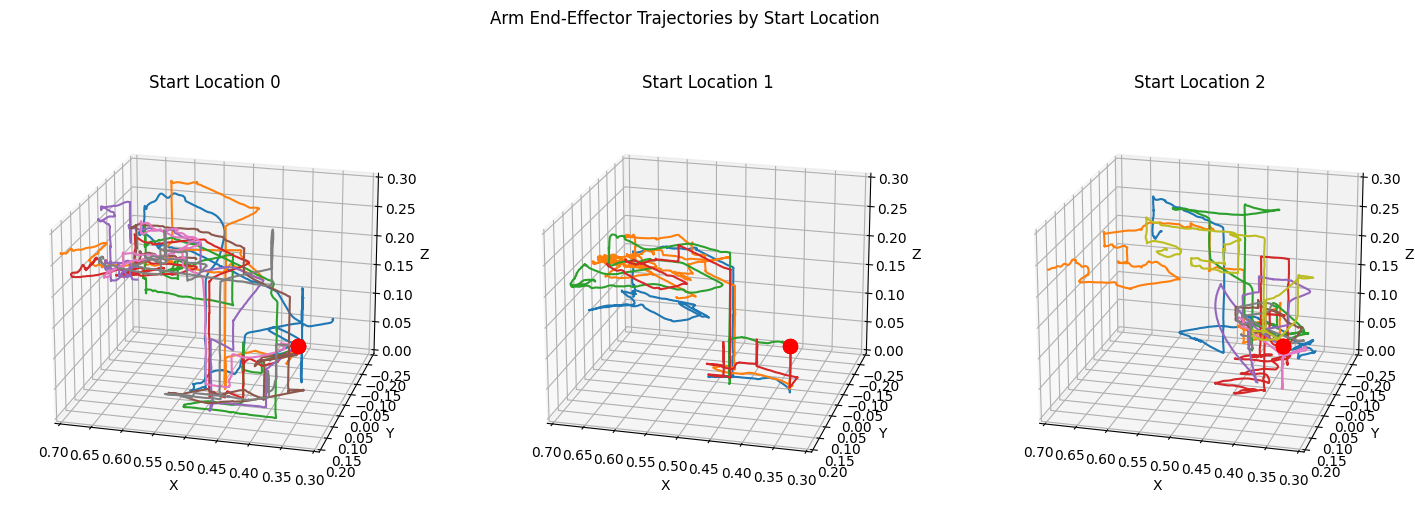

In [70]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D plotting in older matplotlib
import numpy as np

def plot_arm_trajectories(ax, data, user_ids, topic='/my_gen3_lite/base_feedback'):
    """
    Plots the end-effector (tool) trajectory for the given user_ids on a provided 3D axis.
    """
    for user_number in user_ids:
        # Check if the topic exists for this user
        if topic not in data[user_number]:
            print(f"Topic '{topic}' not found for user {user_number}. Skipping...")
            continue
        
        x_vals = []
        y_vals = []
        z_vals = []

        # Extract the tool pose from each feedback message
        for msg in data[user_number][topic]:
            # Each msg is presumably a feedback message with:
            #   msg.base.tool_pose_x, msg.base.tool_pose_y, msg.base.tool_pose_z
            x_vals.append(msg.base.tool_pose_x)
            y_vals.append(msg.base.tool_pose_y)
            z_vals.append(msg.base.tool_pose_z)
        
        # Convert to numpy arrays (optional)
        x_vals = np.array(x_vals)
        y_vals = np.array(y_vals)
        z_vals = np.array(z_vals)

        # Plot the 3D trajectory for this user on the given axis
        ax.plot(x_vals, y_vals, z_vals, label=f"User {user_number}")

        # add a dot at the start and end of the trajectory, set marker size to 10
        ax.scatter(x_vals[0], y_vals[0], z_vals[0], c='r', marker='o', s=100)
        #ax.scatter(x_vals[-1], y_vals[-1], z_vals[-1], c='g', marker='o')

    # If you want a legend for each subplot:
    # ax.legend()

# Now create a 1×3 figure with 3D subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': '3d'})

# Loop through the 3 start locations (assumed to be 0, 1, 2)
for i in range(3):
    # Collect all user_ids for the given start location
    user_list = [uid for uid in id_index if data[uid]['csv_info']['Start Location'] == i]
    
    # Plot on the i-th axis
    plot_arm_trajectories(axs[i], data, user_list, topic='/my_gen3_lite/base_feedback')
    
    # Set labels and title for each subplot
    axs[i].set_xlabel("X")
    axs[i].set_ylabel("Y")
    axs[i].set_zlabel("Z")
    axs[i].set_title(f"Start Location {i}")
    # set x y z limits to be the same
    axs[i].set_xlim(0.3, 0.7)
    axs[i].set_ylim(-0.25, 0.2)
    axs[i].set_zlim(0, 0.3)

    # set view angle
    axs[i].view_init(azim=105, elev=20)

plt.suptitle("Arm End-Effector Trajectories by Start Location")
plt.show()
